# Attention-Weighted Integrated Gradients for Target-Aware Cyberbullying Detection

## Colab Setup

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# Folder to mount
FOLDERNAME = 'cs329t/project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Ensure the Python interpreter of the Colab VM can load python files
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# cd into the dataset
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs329t/project


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Imports
import sys
import importlib
import subprocess
from pathlib import Path

# if running from within truera repo and want to use latest code, use this:
sys.path.insert(0, str(Path("../..").resolve()))

def install_if_not_installed(packages):
  """Install the given packages if they are not already installed."""

  for package in packages:
    if isinstance(package, tuple):
      package_name, package_package = package
    else:
      package_name = package
      package_package = package

    print(f"{package_name} ... ", end='')

    try:
      importlib.import_module(package_name)
      print("already installed")

    except:
      print(f"installing from {package_package}")
      subprocess.check_call(
          [sys.executable, "-m", "pip", "install", package_package]
      )

def load_or_make(filename: Path, loader, maker=None, saver=None, downloader=None):
  """Load something from a `filename` using `loader` if the file exists, 
  otherwise make it using `maker`, save it using `saver`, and return it."""

  print(f"loading {filename} ... ", end="")

  if filename.exists():
    print("from file")
    return loader(filename)
  
  if maker is not None:
    print("using maker")
    thing = maker()
    saver(filename, thing)
    return thing

  if downloader is not None:
    print("using downloader")
    downloader(filename)
    return loader(filename)

  raise ValueError("provide a maker/saver or downloader.")

install_if_not_installed(
    [("trulens", "git+https://github.com/truera/trulens.git@piotrm/vis/output-detect"),
     "transformers",
     "pandas",
     "numpy",
     "domonic",
     "parmap"]
)

# Configure trulens
import os
os.environ['TRULENS_BACKEND']='torch'

from IPython.display import display
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import re

from torch.utils.data import DataLoader
from pandas import Series
from typing import Union
import parmap

trulens ... already installed
transformers ... already installed
pandas ... already installed
numpy ... already installed
domonic ... already installed
parmap ... already installed


## Twitter Roberta BASE Sentiment Model

In [4]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

# Wrap all of the necessary components.
class TwitterSentiment:
    #device = 'cpu'
    device = 'cuda:0'
    MODEL = f'cardiffnlp/twitter-roberta-base-sentiment-latest'
    model = AutoModelForSequenceClassification.from_pretrained(MODEL, output_attentions=True).to(device)
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    @staticmethod
    def tokenize(inputs):
        return TwitterSentiment \
            .tokenizer(inputs, padding=True, return_tensors='pt') \
            .to(TwitterSentiment.device)

    labels = ['negative', 'neutral', 'positive']
    NEGATIVE = labels.index('negative')
    NEUTRAL = labels.index('neutral')
    POSITIVE = labels.index('positive')

task = TwitterSentiment()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Hatespeech Dataset

In [5]:
import csv

# Load CSV file
def load_csv(file_path):
  with open(file_path, newline='') as csv_file:
    reader = csv.reader(csv_file)
    csv_data = list(reader)
  return csv_data

csv_data = load_csv('data/target_test_clean.csv')

In [6]:
def format_data(csv_data):
  formatted_dataset = list()
  for example in csv_data[1:]:
    text = example[0]
    targets = [word for word in text.split() if word.startswith('@') or word.startswith('.@')]
    polarity = example[-1]
    formatted_dataset.append([text, targets, polarity])
  return formatted_dataset
  
dataset = format_data(csv_data)

## Evaluate Baseline

In [17]:
from sklearn.metrics import accuracy_score

def model_predict(task, dataset):
  model_preds = list()
  # Cannot parallelize (CUDA out-of-memory error)
  for example in dataset:
    model_input = task.tokenize(example[0])
    model_output = task.model(**model_input)
    model_pred = task.labels[model_output.logits.argmax(axis=1)]
    if model_pred == 'negative':
      model_preds.append(0)
    elif model_pred == 'neutral':
      model_preds.append(1)
    elif model_pred == 'positive':
      model_preds.append(1)
  return model_preds

def model_accuracy(model_preds, dataset):
  dataset_labels = [int(example[-1]) for example in dataset]
  accuracy = accuracy_score(dataset_labels, model_preds)
  return accuracy

In [ ]:
baseline_preds = model_predict(task, dataset)
baseline_acc = model_accuracy(baseline_preds, dataset)
print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.7885806007796377


## Fairness

### Identify biased targets

In [24]:
def target_sentiments(task, dataset):
  positive_targets = list()
  neutral_targets = list()
  negative_targets = list()
  for example in dataset:
    targets = example[1]
    for target in targets:
      input = task.tokenize(target)
      output = task.model(**input)
      pred = task.labels[output.logits.argmax(axis=1)]
      if pred == 'negative':
        negative_targets.append((target, output[0].tolist()[0][0]))
      elif pred == 'neutral':
        neutral_targets.append((target, output[0].tolist()[0][1]))
      elif pred == 'positive':
        positive_targets.append((target, output[0].tolist()[0][2]))
  negative_targets.sort(key=lambda x: x[1], reverse=True)
  neutral_targets.sort(key=lambda x: x[1], reverse=True)
  positive_targets.sort(key=lambda x: x[1], reverse=True)
  return negative_targets, neutral_targets, positive_targets

negative_targets, neutral_targets, positive_targets = target_sentiments(task, dataset)

In [25]:
print('Number of negative targets found :', len(negative_targets))
print('Top 5 most negative targets', negative_targets[:5])

print('Number of neutral targets found :', len(neutral_targets))
print('Top 5 most neutral targets', neutral_targets[:5])

print('Number of positive targets found :', len(positive_targets))
print('Top 5 most positive targets', positive_targets[:5])

Number of negative targets found : 32
Top 5 most negative targets [('@DumbPeopleAsf', 1.8981472253799438), ('@_theworst__:', 1.7498716115951538), ('@FuckedYaBxtch:', 1.7437477111816406), ('@crooksandliars', 1.6455068588256836), ('@crooksandliars', 1.6455068588256836)]
Number of neutral targets found : 6561
Top 5 most neutral targets [('@HayleyKiyoko', 2.1052064895629883), ('@Amish_Drive_By:', 2.086219072341919), ('@_Geidner_', 2.065882444381714), ('.@RickReedMedia', 2.0423266887664795), ('@Rick_Turner:', 2.015005350112915)]
Number of positive targets found : 18
Top 5 most positive targets [('@BestVinesEver', 2.3773140907287598), ('@_RatedGorgeous', 2.022414207458496), ('@amazingatheist', 1.6356147527694702), ('@uniqueblessed:', 1.5953513383865356), ('@GoodBecameGreat', 1.5624524354934692)]


### Neutralize targets

In [7]:
def neutralize_dataset(dataset):
  neutralized_dataset = list()
  for example in dataset:
    text = example[0]
    targets = example[1]
    polarity = example[-1]
    for target in targets:
      text = text.replace(target, '@username')
    neutralized_dataset.append([text, targets, polarity])
  neutralized_dataset = [example for example in neutralized_dataset if '@username' in example[0]]
  return neutralized_dataset

neutralized_dataset = neutralize_dataset(dataset)

In [93]:
neutralized_preds = model_predict(task, neutralized_dataset)
neutralized_acc = model_accuracy(neutralized_preds, neutralized_dataset)
print('Neutralized accuracy:', neutralized_acc)

Neutralized accuracy: 0.7953027860925628


### Biased datasets

In [ ]:
def create_biased_dataset(dataset, new_target):
  biased_dataset = list()
  for example in dataset:
    text = example[0]
    targets = example[1]
    polarity = example[-1]
    text = text.replace('@username', new_target)
    biased_dataset.append([text, targets, polarity])
  return biased_dataset

negative_dataset = create_biased_dataset(neutralized_dataset, negative_targets[0][0])
positive_dataset = create_biased_dataset(neutralized_dataset, positive_targets[0][0])
biased_datasets = {'@DumbPeopleAsf (negative)': negative_dataset,
                   '@BestVinesEver (positive)': positive_dataset}

### Disparity of logits histogram

In [ ]:
def model_logits(task, dataset):
  logits_list = list()
  for example in dataset:
    input = task.tokenize(example[0])
    output = task.model(**input)
    logits = output['logits'].detach().to('cpu')
    logits_list.append(logits)
  models_logits = np.stack(list(map(torch.Tensor.numpy, logits_list)))
  models_logits = models_logits.reshape((models_logits.shape[0], 3))
  return models_logits

biased_logits = {username: model_logits(task, biased_dataset) for username, biased_dataset in biased_datasets.items()}

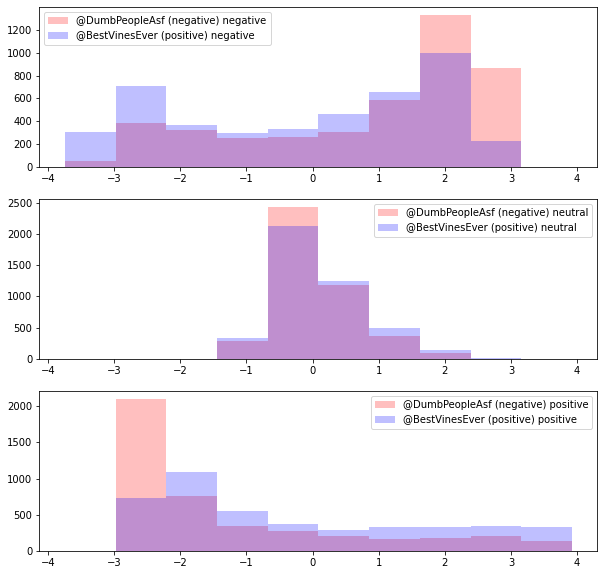

In [ ]:
amin = min(logits.min() for logits in biased_logits.values())
amax = max(logits.max() for logits in biased_logits.values())

# Figure showing the histogram of logits for each of the three classes
colors = {'@DumbPeopleAsf (negative)': 'red', '@BestVinesEver (positive)': 'blue'}
fig, axs = plt.subplots(3,1, figsize=(10,10))
for idx, label in zip([task.NEGATIVE, task.NEUTRAL, task.POSITIVE], task.labels):
    for username, logits in biased_logits.items():
        axs[idx].hist(logits[:, idx], bins=10, alpha=0.25, label=f"{username} {label}", color=colors[username], range=(amin, amax))
    axs[idx].legend()

### Most disparate tweets

In [8]:
from trulens.nn.models import get_model_wrapper

task.wrapper = get_model_wrapper(task.model, input_shape=(None, task.tokenizer.model_max_length), device=task.device)

INFO: lib level=1
INFO: root level=30
INFO: Detected pytorch backend for <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>.
INFO: Using backend Backend.PYTORCH.
INFO: If this seems incorrect, you can force the correct backend by passing the `backend` parameter directly into your get_model_wrapper call.
DEBUG: Input dtype was not passed in. Defaulting to `torch.float32`.


In [9]:
from trulens.visualizations import NLP

V = NLP(
    wrapper=task.wrapper,
    labels=task.labels,
    decode=lambda x: task.tokenizer.decode(x),
    tokenize=task.tokenize,
    # huggingface models can take as input the keyword args as per produced by their tokenizers.

    input_accessor=lambda x: x['input_ids'],
    # for huggingface models, input/token ids are under input_ids key in the input dictionary

    output_accessor=lambda x: x['logits'],
    # and logits under 'logits' key in the output dictionary

    hidden_tokens=set([task.tokenizer.cls_token_id, task.tokenizer.bos_token_id, task.tokenizer.eos_token_id, task.tokenizer.pad_token_id])
    # do not display these tokens
)

In [ ]:
# Top 10 most disparate tweets
def most_disparate_tweets(biased_datasets, biased_logits, num_tweets=10):
  disparate_idxs = np.argsort(abs(biased_logits['@DumbPeopleAsf (negative)'] - biased_logits['@BestVinesEver (positive)']).sum(axis=1))[::-1]
  negative_disparate_tweets = list()
  positive_disparate_tweets = list()
  for tweet_idx in disparate_idxs:
    if len(negative_disparate_tweets) == num_tweets:
      break
    if biased_datasets['@DumbPeopleAsf (negative)'][tweet_idx][0].count('@') > 1:
      continue
    negative_disparate_tweets.append(biased_datasets['@DumbPeopleAsf (negative)'][tweet_idx][0])
    positive_disparate_tweets.append(biased_datasets['@BestVinesEver (positive)'][tweet_idx][0])
  return negative_disparate_tweets, positive_disparate_tweets

negative_disparate_tweets, positive_disparate_tweets = most_disparate_tweets(biased_datasets, biased_logits)
V.tokens_stability(
    texts1 = negative_disparate_tweets,
    texts2 = positive_disparate_tweets
)

## Robustness

### Integrated Gradients baseline

In [10]:
from trulens.utils.nlp import token_baseline

# Get token IDs for '@username to add to baseline
tokenized_target = task.tokenize(' @username')
target_token_ids = tokenized_target['input_ids'].tolist()[0][1:3]

inputs_baseline_ids, inputs_baseline_embeddings = token_baseline(
    keep_tokens=set([task.tokenizer.cls_token_id, task.tokenizer.bos_token_id, task.tokenizer.eos_token_id] + target_token_ids),
    # Which tokens to preserve.
    replacement_token=task.tokenizer.pad_token_id,
    # What to replace tokens with.
    input_accessor=lambda x: x.kwargs['input_ids'],
    ids_to_embeddings=task.model.get_input_embeddings()
    # Callable to produce embeddings from token ids.
)

In [12]:
from trulens.utils.typing import ModelInputs

tokenized_example = task.tokenize(neutralized_dataset[85][0])
print('originals=', task.tokenizer.batch_decode(tokenized_example['input_ids']))

baseline_word_ids = inputs_baseline_ids(model_inputs=ModelInputs(kwargs=tokenized_example))
print('baselines=', task.tokenizer.batch_decode(baseline_word_ids))

originals= ["<s>RT @username I bet Bear Grylls' barbecues are awful. Everyone expecting burgers and sausages, whilst he roasts dog shits and boils pin…</s>"]
baselines= ['<s><pad> @username<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad></s>']


### Integrated Gradients

In [11]:
from trulens.nn.distributions import LinearDoi
from trulens.nn.quantities import LambdaQoI, ComparativeQoI
from trulens.nn.attribution import Cut, OutputCut, InputAttribution

# Example tweets
neutralized_tweets = [neutralized_dataset[85][0], neutralized_dataset[190][0]]

# LinearDoi is the same as Integrated Gradients
attr_cut = Cut('roberta_embeddings_word_embeddings')
doi = LinearDoi(baseline=inputs_baseline_embeddings,  resolution=50, cut=attr_cut)

# Lambda QoI (max(positive, neutral) - negative)
def custom_qoi(logits):
  max_neutral_positive = torch.maximum(logits[:, 1], logits[:, 2])
  negative = logits[:, 0]
  difference = max_neutral_positive - negative
  return torch.sum(difference)
lambda_qoi = LambdaQoI(custom_qoi)
# Comparative QoI (Not used)
# comparative_qoi = ComparativeQoI(task.POSITIVE, task.NEGATIVE)

infl = InputAttribution(
    model = task.wrapper,
    doi=doi,
    doi_cut=attr_cut,
    qoi=lambda_qoi,
    qoi_cut=OutputCut(accessor=lambda o: o['logits'])
)
display(
    V.tokens(neutralized_tweets, attributor=infl),
)

### Token Attribution based Sentiment Analysis

In [12]:
def evaluate_vanilla_attribution(task, dataset):
  model_scores = list()
  # Cannot parallelize (CUDA out-of-memory error)
  with torch.no_grad():
    for example in dataset:
      model_input = task.tokenize(example[0])
      model_output = task.model(**model_input)
      model_logits = model_output.logits
      negative_score = model_logits[0][0]
      neutral_score = model_logits[0][1]
      positive_score = model_logits[0][2]
      max_neutral_positive_score = max(neutral_score, positive_score)
      attr_score = max_neutral_positive_score - negative_score
      model_scores.append(attr_score)
  return model_scores

In [15]:
def score_to_prediction(scores, threshold=0):
  model_preds = list()
  for score in scores:
    if score <= threshold:
      model_preds.append(0)
    else:
      model_preds.append(1)
  return model_preds

In [18]:
vanilla_scores = evaluate_vanilla_attribution(task, neutralized_dataset)
vanilla_preds = score_to_prediction(vanilla_scores, threshold=0)
vanilla_acc = model_accuracy(vanilla_preds, neutralized_dataset)
print('Token Attribution based accuracy:', vanilla_acc)

Token Attribution based accuracy: 0.7953027860925628


### Attention-Weighted Token Attribution based Sentiment Analysis

In [19]:
from trulens.nn.backend import get_backend
from trulens.utils.typing import nested_cast, ModelInputs

B = get_backend()

def to_numpy(input):
  return np.array(nested_cast(B, input, np.ndarray))

def get_token_attr_attn(task, attributor, text, head_mode, layer_mode):
  tokenized_text = task.tokenize(text)
  decoded_text = task.tokenizer.batch_decode(tokenized_text['input_ids'][0])
  model_inputs = ModelInputs(kwargs=tokenized_text)
  model_attr = attributor._attributions(model_inputs)
  numpy_attr = to_numpy(model_attr.attributions)[0, 0]
  token_attr = numpy_attr[0].sum(axis=1)
  attribution_list = list()

  for token_idx in range(len(decoded_text)):
    token = decoded_text[token_idx]
    attr = token_attr[token_idx]
    attribution_list.append((token, attr))
  
  attention = task.model(tokenized_text['input_ids'])['attentions']
  # username token is 48852
  try:
    target_idx = tokenized_text['input_ids'][0].tolist().index(48852)
  except:
    return None, None
    
  with torch.no_grad():
    num_heads=12
    num_layers = len(attention)
    inp_len = attention[0].shape[-1]
    head_attn = torch.zeros([num_layers,inp_len]).to(task.device)
    attn = torch.zeros([inp_len]).to(task.device)
    for layer, l_attn in enumerate(attention):
      for idx in range(inp_len):
        for h in range(num_heads):
          if idx is not target_idx:
            if head_mode is "max":
              head_attn[layer][idx] = max(head_attn[layer][idx],attention[layer][0,h,idx,target_idx])    
            elif head_mode is "avg":                
              head_attn[layer][idx] += attention[layer][0,h,idx,target_idx]/num_heads
        
        if layer_mode is "max":
          attn[idx] = max(attn[idx],head_attn[layer][idx])
        elif layer_mode is "avg":
          attn[idx] += head_attn[layer][idx]/num_layers

    normalized_attn = attn / (sum(attn) + 1e-7)
    return attribution_list, normalized_attn

In [22]:
from tqdm import tqdm

def get_attn_weighted_scores(task, infl, dataset, head_mode, layer_mode):
  model_scores = list()
  for example_idx, example in tqdm(enumerate(dataset), total=len(dataset)):
    token_attr, attn = get_token_attr_attn(task, infl, example[0], head_mode, layer_mode)
    score = 0
    if head_mode is None and layer_mode is None:
      score = [attr for score, attr in token_attr]
    else:
      for token_idx, (token, attr) in enumerate(token_attr):
          score += attn[token_idx] * attr * attn.shape[0]
    model_scores.append(score)
  return model_scores

In [23]:
attn_weighted_scores = get_attn_weighted_scores(task, infl, neutralized_dataset, 'max', 'max')

100%|██████████| 4343/4343 [29:52<00:00,  2.42it/s]


In [36]:
attn_weighted_preds = score_to_prediction(attn_weighted_scores, threshold=0)

In [37]:
attn_weighted_acc = model_accuracy(attn_weighted_preds, neutralized_dataset)
print('Attention-weighted token attribution based accuracy:', attn_weighted_acc)

Attention-weighted token attribution based accuracy: 0.8047432650241768
